In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Native libraries
import os
import math


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the data
data = pd.read_csv("Credit_Card/fraudTest.csv")
data.drop( columns= 'Unnamed: 0', inplace= True)
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])


In [3]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [4]:
#Removing not important data
data.drop( columns= ['unix_time','zip','city_pop','trans_num','street','last','first'], inplace= True)

In [5]:
data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,lat,long,job,dob,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,Columbia,SC,33.9659,-80.9355,Mechanical engineer,1968-03-19,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,F,Altonah,UT,40.3207,-110.4360,"Sales professional, IT",1990-01-17,39.450498,-109.960431,0


Since long and lat are not really usable, I create the distance long^2 + lat^2 = d^2

In [6]:
n = 2
data['user_d'] = np.sqrt( np.power( data['long'],n) + np.power( data['lat'],n) )
data['local_d'] = np.sqrt( np.power( data['merch_long'],n) + np.power( data['merch_lat'],n) )

data['distance_user_local'] = np.sqrt( np.power( data['merch_long'] - data['long'],n) + np.power( data['merch_lat'] -  data['lat'],n) )

In [7]:
data['age'] = pd.to_datetime('today').year - pd.to_datetime( data['dob'],format='%Y-%m-%d').dt.year

In [8]:
data.drop( columns= ['long','lat','merch_long','merch_lat','dob','merchant','user_d','local_d',], inplace= True)

In [9]:
data = data.sort_values(by=['cc_num','trans_date_trans_time'])

data['day_of_year'] = data['trans_date_trans_time'].dt.day_of_year
data['month_of_year'] = data['trans_date_trans_time'].dt.month
    

In [10]:
#Removing the first month of transactions since the first month do not provide enough behavioral data
data = data.drop(data[data['month_of_year'] == 6].index)

In [11]:
data.reset_index(drop=True, inplace= True)

In [12]:
data['seconds_between_transaction'] = data['trans_date_trans_time'] - data['trans_date_trans_time'].shift(1)
data['seconds_between_transaction'] = data['seconds_between_transaction'].dt.total_seconds()
data['seconds_between_transaction'] = data['seconds_between_transaction'].fillna(0)

In [13]:
for cc in data['cc_num'].unique():
    cc_mask = data['cc_num'] == cc
    
    for day in data[cc_mask]['day_of_year'].unique():
        day_mask = (cc_mask) & (data['day_of_year'] == day)
        
        # Find the indices where the condition is True
        indices = data.index[day_mask][0]
        
        # Update the 'seconds_between_transaction' column directly for the selected indices
        data.loc[indices, 'seconds_between_transaction'] = 0


In [14]:
data.drop(columns=['month_of_year','day_of_year'], inplace= True)
data.drop(columns=['job','city','state'], inplace= True)

In [15]:
data.head(5)

,trans_date_trans_time,cc_num,category,amt,gender,is_fraud,distance_user_local,age,seconds_between_transaction
0,2020-07-01 18:05:37,60416207185,shopping_pos,9.33,F,0,1.007351,38,0.0
1,2020-07-01 18:14:59,60416207185,personal_care,1.79,F,0,0.031852,38,562.0
2,2020-07-01 21:23:57,60416207185,home,14.65,F,0,0.979536,38,11338.0
3,2020-07-01 21:28:33,60416207185,shopping_net,8.82,F,0,0.465446,38,276.0
4,2020-07-02 12:51:21,60416207185,travel,4.86,F,0,0.554224,38,0.0


array([[<Axes: title={'center': 'trans_date_trans_time'}>,
        <Axes: title={'center': 'cc_num'}>,
        <Axes: title={'center': 'amt'}>],
       [<Axes: title={'center': 'is_fraud'}>,
        <Axes: title={'center': 'distance_user_local'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'seconds_between_transaction'}>,
        <Axes: >, <Axes: >]], dtype=object)

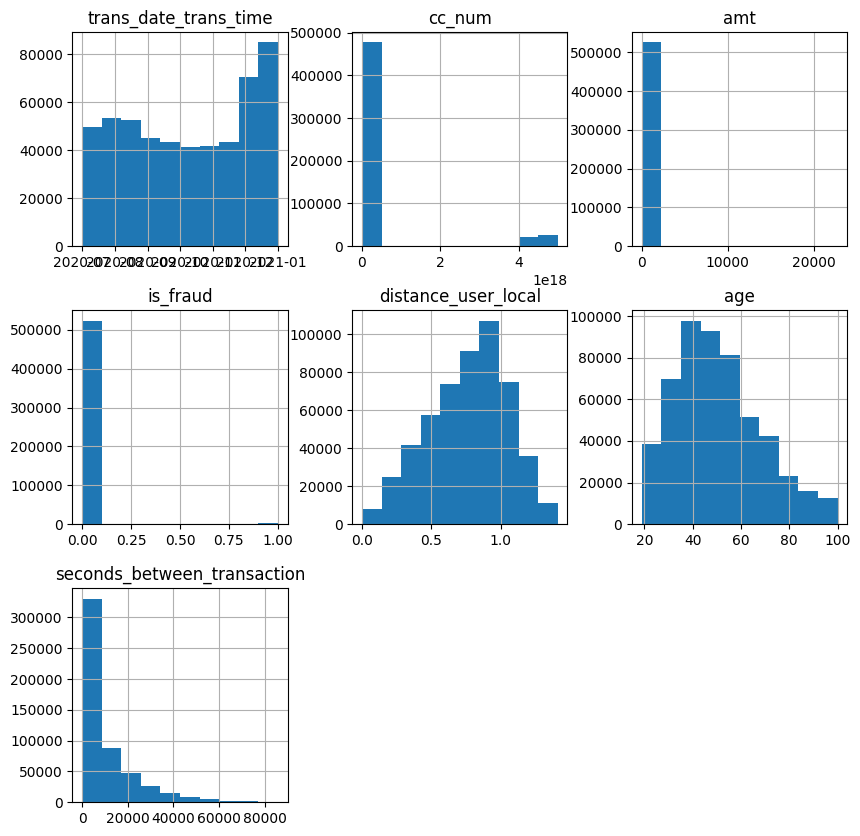

In [16]:
data.hist(figsize=(10,10))

Check histplots

In [17]:
df = data.copy()

In [18]:
df.head()

,trans_date_trans_time,cc_num,category,amt,gender,is_fraud,distance_user_local,age,seconds_between_transaction
0,2020-07-01 18:05:37,60416207185,shopping_pos,9.33,F,0,1.007351,38,0.0
1,2020-07-01 18:14:59,60416207185,personal_care,1.79,F,0,0.031852,38,562.0
2,2020-07-01 21:23:57,60416207185,home,14.65,F,0,0.979536,38,11338.0
3,2020-07-01 21:28:33,60416207185,shopping_net,8.82,F,0,0.465446,38,276.0
4,2020-07-02 12:51:21,60416207185,travel,4.86,F,0,0.554224,38,0.0


In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:

cat_columns = ['gender','category']
category_data = df[cat_columns]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid the dummy variable trap

# Fit and transform the categorical column
encoded_data = encoder.fit_transform(category_data)

In [21]:
# Create a DataFrame with the encoded values and column names
encoded_df = pd.DataFrame(encoded_data, columns= encoder.get_feature_names_out(cat_columns))


In [23]:
df = pd.concat([df, encoded_df], axis=1)

df = df.drop(cat_columns, axis=1)

In [39]:
df.head()

,amt,is_fraud,distance_user_local,age,seconds_between_transaction,gender_M,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,9.33,0,1.007351,38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.79,0,0.031852,38,562.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,14.65,0,0.979536,38,11338.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.82,0,0.465446,38,276.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.86,0,0.554224,38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
df.drop( columns= ['trans_date_trans_time','cc_num'], inplace= True)

In [38]:
df.drop_duplicates(inplace=True)

<Axes: xlabel='is_fraud', ylabel='distance_user_local'>

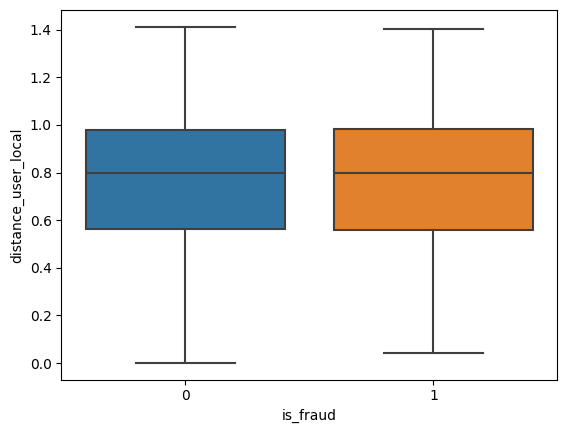

In [28]:
sns.boxplot(data, y= 'distance_user_local', x = 'is_fraud')

<Axes: xlabel='is_fraud', ylabel='amt'>

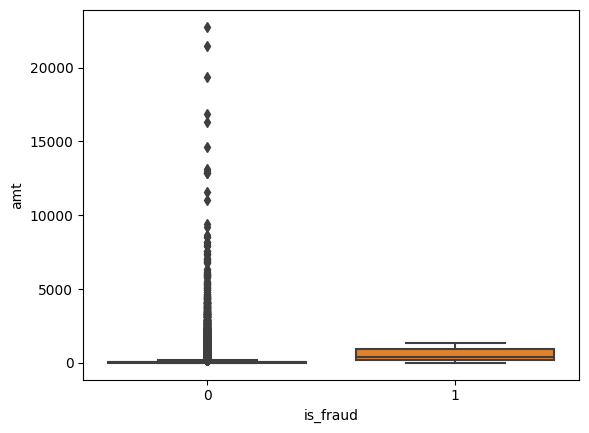

In [29]:
sns.boxplot(data, y= 'amt', x = 'is_fraud')

<Axes: xlabel='is_fraud', ylabel='age'>

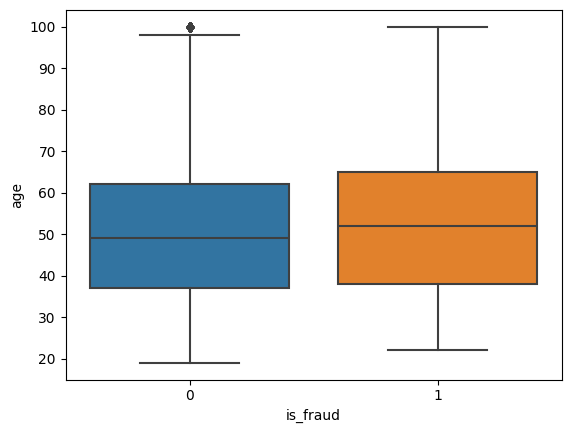

In [30]:
sns.boxplot(data, y= 'age', x = 'is_fraud')

In [44]:
df.columns

Index(['amt', 'is_fraud', 'distance_user_local', 'age',
       'seconds_between_transaction', 'gender_M', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel'],
      dtype='object')

In [86]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [49]:
df = df.drop_duplicates()

In [66]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['amt', 'is_fraud', 'distance_user_local', 'age','seconds_between_transaction']])

In [82]:
np_array = np.concatenate((df_scaled, df[encoder.get_feature_names_out(cat_columns)].to_numpy()), axis=1)

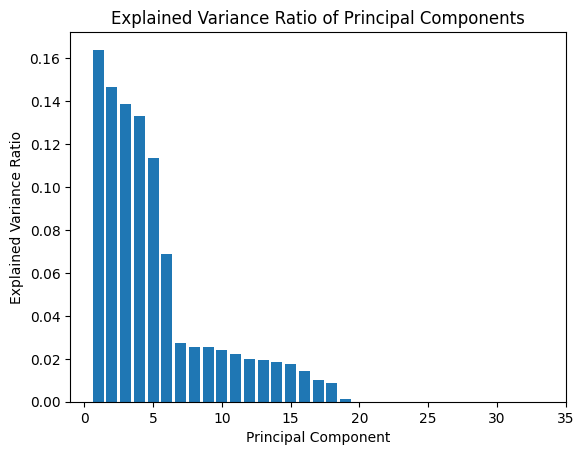

In [88]:
# Apply PCA
pca = PCA(n_components=len(np_array[0]))  # You can adjust the number of components
df_pca = pca.fit_transform(np_array)

# Plot the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score